In [5]:
using MAT
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Glob
using DelimitedFiles
using NPZ

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16565959135061092301\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16700026520183753883\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16565959135061092301\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [6]:
#expects path to the position file and types file.
function getdata(positionfilename, typesfilename)
    posarray = readdlm(positionfilename, ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        posarray[j] = chop(posarray[j]);
        if(occursin("e", posarray[j]))
            error(positionfilename)
        end
        xsign = 1;
        x_y = split(posarray[j], '-');
        if(x_y[1] == "")
            xsign = -1;
            x_y = deleteat!(x_y,1);
        end
        x_plus_y = [];
        if(size(x_y)[1] == 1)
            x_plus_y = split(posarray[j], '+');
            x_plus_y = map(a->parse(Float64,a),x_plus_y);
            push!(posx, x_plus_y[1]);
            push!(posy, x_plus_y[2]);
        else
            x_y = map(a->parse(Float64,a),x_y);
            x_y[1] *= xsign;
            x_y[2] *= -1;
            push!(posx,x_y[1]);
            push!(posy,x_y[2]);
        end
    end
    typesarray = readdlm(typesfilename, ',','\n');
    typesarray = Array{Int64,2}(typesarray)
    positions = transpose(hcat(posx, posy))
    return (positions, typesarray);
end

getdata (generic function with 1 method)

In [7]:
function getdatafortypealltime(typeofsimunderscore, numberofsim)
    eachsim = Dict{Int64, Any}();
    for i in 1:numberofsim
        totaldata = []
        foldername = string("DAH_",typeofsimunderscore, "_",i);
        for j in 1:100
            positionnum = lpad((j-1)*10000,7,"0");
            filename = string(foldername , "/Pos_",positionnum, ".dat");
            typefilename = string(foldername,  "/Types_",positionnum,".dat");
            (a,b) = getdata(filename,typefilename);
            push!(totaldata, (a,b));
        end
        push!(eachsim, i => totaldata);
    end
    return eachsim;
end

getdatafortypealltime (generic function with 1 method)

In [8]:
function calculategammamean(typecell, positiondata,typedata)
    n = size(positiondata,2);
    meangamma = 0;
    for i in 1:n
        totalneighbor = 0;
        differentneighbor = 0;
        currentpoint = positiondata[:,i];
        typeofpoint = typedata[i];
        if(typeofpoint == typecell)
            for j in 1:n
                otherpoint = positiondata[:,j];
                othertype = typedata[j]
                distance = ((otherpoint[1]- currentpoint[1])^2 +(otherpoint[2]- currentpoint[2])^2)^0.5;
                if(distance <= 1.01)
                    totalneighbor += 1;
                    if(othertype != typecell)
                        differentneighbor +=1;
                    end
                end
            end
        end
        if(totalneighbor == 0)
            totalneighbor = 0.000000000000000001;
        end
        gammaforthis = differentneighbor/totalneighbor;
        meangamma += gammaforthis;
    end
    meangamma = meangamma/n;
    return meangamma    
end

calculategammamean (generic function with 1 method)

In [9]:
completesortingalldatatime = getdatafortypealltime("Complete_Sorting",5);
lipidbilayeralldatatime = getdatafortypealltime("Lipid_Bilayer",5);
twophasealldatatime = getdatafortypealltime("Two_Phase",5);

In [10]:
completegamma = Array{Float64}(undef,5,100);
bilayergamma = Array{Float64}(undef,5,100);
twophasegamma =Array{Float64}(undef,5,100);
for j in 1:5
    for i in 1:100 
        pos,typedat = completesortingalldatatime[j][i]
        completegamma[j,i] = calculategammamean(1,pos,typedat);
        posb,typedatb = lipidbilayeralldatatime[j][i]
        bilayergamma[j,i] = calculategammamean(1,posb,typedatb);
        post,typedatt = twophasealldatatime[j][i]
        twophasegamma[j,i] = calculategammamean(1,post,typedatt);
        
    end
end

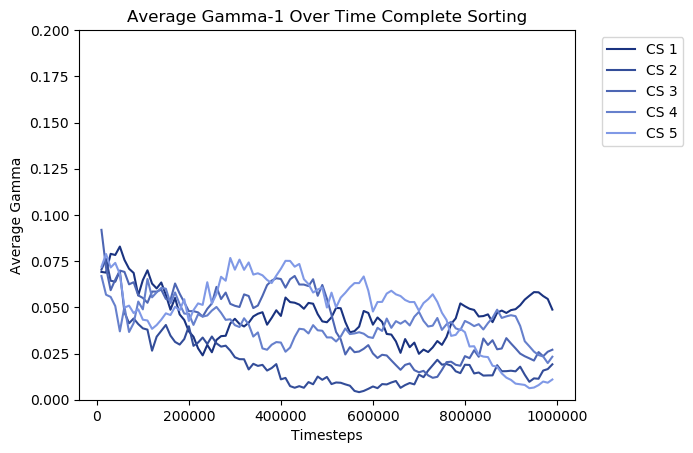

Figure(PyObject <Figure size 600x300 with 0 Axes>)

In [38]:
x = 1:10000:1000000;
title("Average Gamma-1 Over Time Complete Sorting")
xlabel("Timesteps")
ylabel("Average Gamma")
ylim(0,0.2)
plot(x[2:end],completegamma[1,2:end], label = "CS 1", color = (0.1, 0.2, 0.5))
plot(x[2:end],completegamma[2,2:end], label = "CS 2", color = (0.2, 0.3, 0.6))
plot(x[2:end],completegamma[3,2:end], label = "CS 3", color = (0.3, 0.4, 0.7))
plot(x[2:end],completegamma[4,2:end], label = "CS 4", color = (0.4, 0.5, 0.8))
plot(x[2:end],completegamma[5,2:end], label = "CS 5", color = (0.5, 0.6, 0.9))
legend(bbox_to_anchor=(1.04,1),loc = "upper left");
figure(figsize=(6,3))

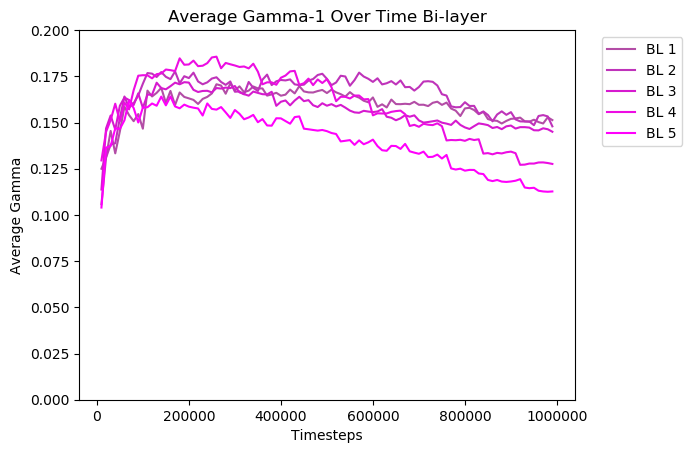

Figure(PyObject <Figure size 600x300 with 0 Axes>)

In [43]:
x = 1:10000:1000000;
title("Average Gamma-1 Over Time Bi-layer")
xlabel("Timesteps")
ylabel("Average Gamma")
ylim(0,0.2)
plot(x[2:end],bilayergamma[1,2:end], label = "BL 1", color = (.7, 0.3, 0.65))
plot(x[2:end],bilayergamma[2,2:end], label = "BL 2", color = (0.75, 0.2, 0.73))
plot(x[2:end],bilayergamma[3,2:end], label = "BL 3", color = (0.84, 0.1, 0.81))
plot(x[2:end],bilayergamma[4,2:end], label = "BL 4", color = (0.93, 0.05, 0.89))
plot(x[2:end],bilayergamma[5,2:end], label = "BL 5", color = (1, 0.0, 0.99))
legend(bbox_to_anchor=(1.04,1),loc = "upper left");
figure(figsize=(6,3))

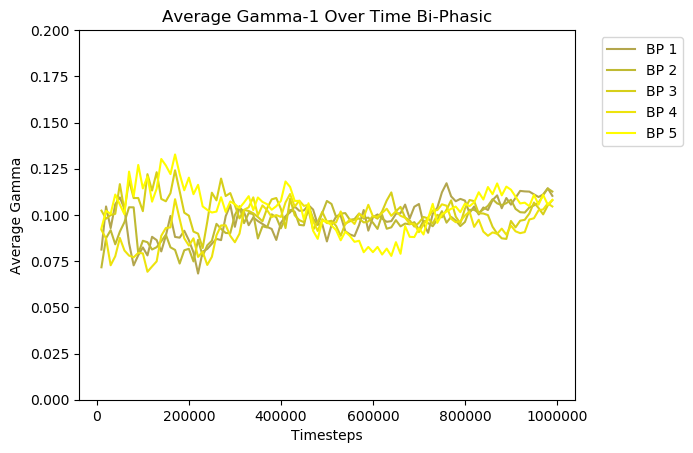

Figure(PyObject <Figure size 600x300 with 0 Axes>)

In [42]:
x = 1:10000:1000000;
title("Average Gamma-1 Over Time Bi-Phasic")
xlabel("Timesteps")
ylabel("Average Gamma")
ylim(0,0.2)
plot(x[2:end],twophasegamma[1,2:end], label = "BP 1", color = (.7, 0.65, 0.3))
plot(x[2:end],twophasegamma[2,2:end], label = "BP 2", color = (0.75, 0.73, 0.2))
plot(x[2:end],twophasegamma[3,2:end], label = "BP 3", color = (0.84, 0.81, 0.1))
plot(x[2:end],twophasegamma[4,2:end], label = "BP 4", color = (0.93, 0.89, 0.05))
plot(x[2:end],twophasegamma[5,2:end], label = "BP 5", color = (1, 0.99, 0.0))
legend(bbox_to_anchor=(1.04,1),loc = "upper left");
figure(figsize=(6,3))